In [ ]:
import tensorflow as tf 
from tensorflow.keras.applications import ResNet50V2, DenseNet201, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import cv2 
import pickle

tf.__version__

'2.3.0'

In [ ]:
def train_model(path, train_images=None, train_labels = None, 
                test_images = None, test_labels = None, 
                model_name = None, epochs =80, learning_rate = 0.0001,
                input_shape = (224,224,3), classes=2, batch_size = 16, 
                classifier_activation='softmax',
                callbacks = None,
                Fold = None):
    '''    
    saves the model as .h5 file\n  
    path = directory for saving the files
    train_images = a numpy array containing the image data for training\n
    train_labels = a numpy array containing the labels for training\n
    test_images = a numpy array containing the image data for test\n
    test_labels = a numpy array containing the labels for test\n
    model_name = a string, name of the model -> "vgg19", "resnet50_v2", "inception_resnet_v2", "densenet201", "inception_v3", "xception", "mobilenet_v2"\n
    epochs\n
    learning_rate\n        
    '''

    base_model = None
     
    if model_name == 'resnet50_v2':
        base_model = ResNet50V2(weights = None, include_top = False, input_shape = input_shape)
 
    if model_name == 'densenet201':        
        base_model = DenseNet201(weights = None, include_top = False, input_shape = input_shape)
          
    if model_name == 'inception_v3':        
        base_model = InceptionV3(weights = None, include_top = False, input_shape = input_shape)


    x = base_model.output         
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(classes, activation=classifier_activation)(x)

    model = tf.keras.Model(inputs = base_model.input, outputs = output)

    optimizer = Adam(learning_rate = learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

    model.compile(optimizer = optimizer,
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = ['accuracy'])
        
    results = model.fit(train_images, train_labels, epochs = epochs,
                        validation_data = (test_images, test_labels), 
                        batch_size=batch_size, 
                        callbacks = callbacks
                        )
    
    losses = pd.DataFrame(model.history.history)
    losses[['loss','val_loss']].plot()
    
    save_model = path + model_name + ' - ' + str(Fold) + '.h5'
    model.save(save_model)

    
    
    return results, model    

In [ ]:
def ensemble(x, weights, models): 
    '''
    returns a weighted average of predictions made by the models\n
    x -> input image \n
    weights -> a list of weights \n
    models -> a list of models\n    
    '''      
    outputs = []    
    for model in models:                
        outputs.append(list(model.predict(x)[0]))                
    
    outputs = np.array(outputs)
    avg = np.average(a=outputs,axis=0,weights=weights)
    return avg


def equal(pred, label):
  pred_id = np.argmax(pred)
  if (pred_id == label):
    return True
  else:
    return False


def accuracy(predicted_values, y_truths):
  '''
  returns accuracy\n
  predicted_values = a numpy array containing the predictions\n
  y_truths = a numpy array containing the truth values\n  
  '''
  total = len(y_truths)
  correct = 0
  for i in range(len(y_truths)):
    if equal(predicted_values[i],y_truths[i]):
      correct += 1
  acc = correct / total
  return acc

In [ ]:
def generate_weights(x_val, y_val, models):

    accuracy = []
    weights = np.full((1,len(models)), 100.0)

    for model in models:
      y_preds = (np.array(model.predict(x_val)))
      y_preds = np.argmax(y_preds, axis=1)
      acc = accuracy_score(y_val, y_preds)
      accuracy.append(100*acc)

    weights = weights - accuracy
    weights = weights**2

    sum = np.sum(weights)
    weights = weights/sum
    weights = 1/weights

    weights = weights**2
    sum = np.sum(weights)

    weights = weights/sum

    return weights

In [ ]:
x_train = np.load('/content/drive/My Drive/CXR_Datasets/Btrain_images.npy')
y_train = np.load('/content/drive/My Drive/CXR_Datasets/Btrain_labels.npy')

x_val = np.load('/content/drive/My Drive/CXR_Datasets/val_images.npy')
y_val = np.load('/content/drive/My Drive/CXR_Datasets/val_labels.npy')

x_test = np.load('/content/drive/My Drive/CXR_Datasets/test_images.npy')
y_test = np.load('/content/drive/My Drive/CXR_Datasets/test_labels.npy')

In [ ]:
print("train ---", np.unique(y_train,return_counts=True))
print("val ---", np.unique(y_val,return_counts=True))
print("test ---", np.unique(y_test,return_counts=True))

train --- (array([0, 1]), array([438, 333]))
val --- (array([0, 1]), array([57, 60]))
test --- (array([0, 1]), array([43, 75]))


In [ ]:
classes = ["COVID_19","NON_COVID"]
image_size = 224
path = '/content/drive/My Drive/Colab Notebooks/New Model/' #path for saving the files

In [ ]:
from sklearn.model_selection import KFold

inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

In [ ]:
inputs.shape

(889, 224, 224, 3)

In [ ]:
targets.shape

(889,)

train --- (array([0, 1]), array([373, 338]))
test --- (array([0, 1]), array([108,  70]))
------------------------------------------------------------------------
Training for fold 1 ...

Training Inception v3

Epoch 1/60
45/45 [==============================] - 9s 190ms/step - loss: 0.4558 - accuracy: 0.8439 - val_loss: 0.6747 - val_accuracy: 0.6067
Epoch 2/60
45/45 [==============================] - 6s 132ms/step - loss: 0.4032 - accuracy: 0.9086 - val_loss: 0.6936 - val_accuracy: 0.6067
Epoch 3/60
45/45 [==============================] - 6s 133ms/step - loss: 0.3687 - accuracy: 0.9395 - val_loss: 0.7053 - val_accuracy: 0.6067
Epoch 4/60
45/45 [==============================] - 6s 134ms/step - loss: 0.3524 - accuracy: 0.9606 - val_loss: 0.7065 - val_accuracy: 0.6067
Epoch 5/60
45/45 [==============================] - 6s 135ms/step - loss: 0.3497 - accuracy: 0.9648 - val_loss: 0.7065 - val_accuracy: 0.6067
Epoch 6/60
45/45 [==============================] - 6s 136ms/step - loss: 0.3454

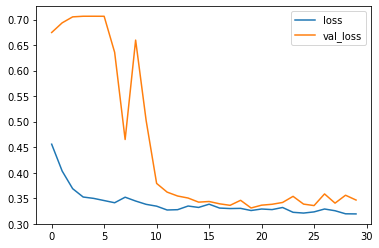

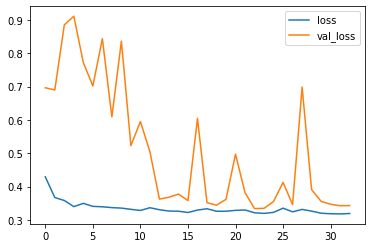

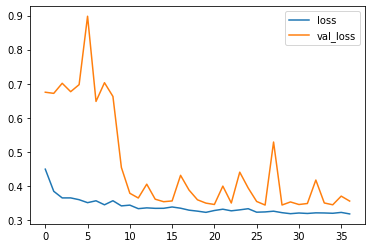

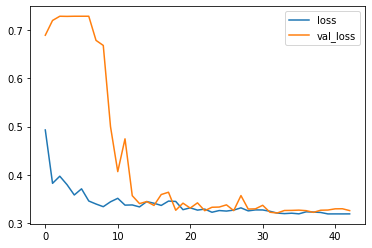

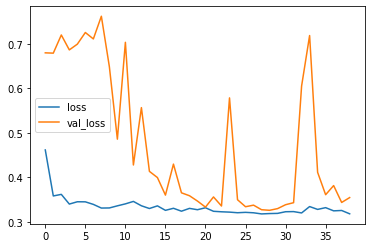

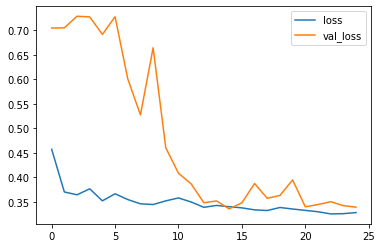

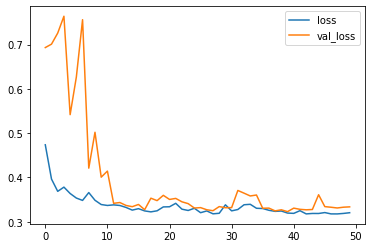

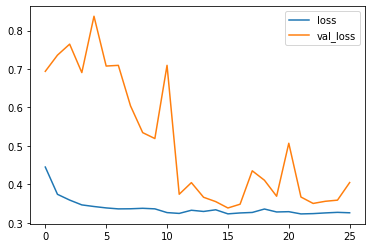

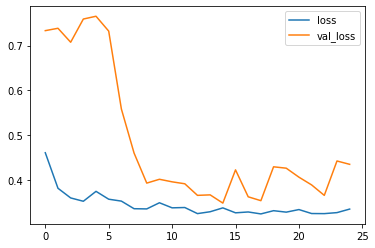

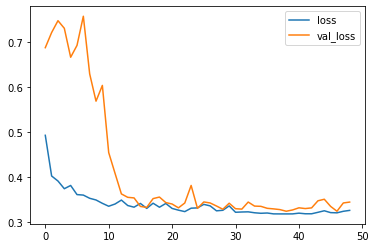

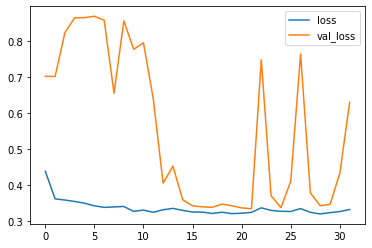

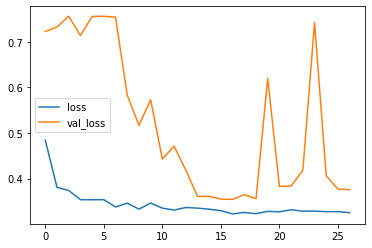

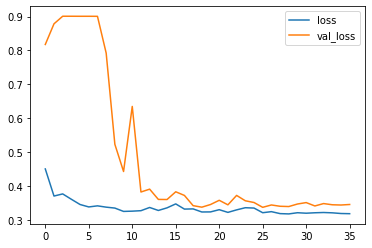

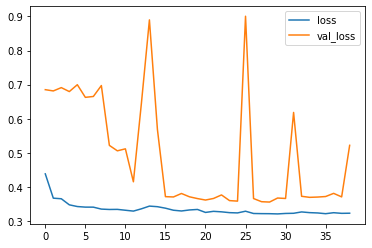

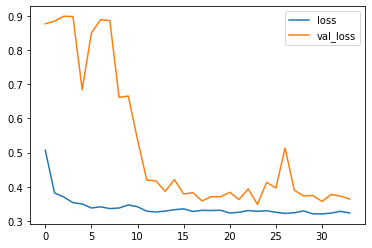

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, 
                           mode='min', restore_best_weights = True)
callbacks = [early_stop]

n_split=5
fold_no=1

for train_index,test_index in KFold(n_split).split(inputs):

  x_train,x_test = inputs[train_index],inputs[test_index]
  y_train,y_test = targets[train_index],targets[test_index]

  print("train ---", np.unique(y_train,return_counts=True))
  print("test ---", np.unique(y_test,return_counts=True))

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  print('\nTraining Inception v3\n')
  inception , model1 = train_model(path, x_train, y_train,
                        x_test, y_test, model_name = "inception_v3",
                        epochs = 60, input_shape = (image_size,image_size,3),
                        classes = len(classes),
                        callbacks = callbacks,
                        Fold = fold_no)
  
  print('\nTraining DenseNet 201\n')
  densenet , model2 = train_model(path, x_train, y_train,
                       x_test, y_test, model_name="densenet201",
                       epochs = 60, input_shape = (image_size,image_size,3),
                       classes = len(classes),
                       callbacks = callbacks,
                       Fold = fold_no)
  
  print('\nTraining ResNet50 v2\n')
  resnet, model3 = train_model(path, x_train, y_train,
                     x_test, y_test, model_name="resnet50_v2",
                     epochs = 60, input_shape = (image_size,image_size,3),
                     classes = len(classes),
                     callbacks = callbacks,
                     Fold = fold_no)
  
  p = '/content/drive/My Drive/Colab Notebooks/New Model/Train History/'

  inception_history = p + 'inception_history_' + str(fold_no) +'.pickle'
  densenet_history = p + 'densenet_history_' + str(fold_no) +'.pickle'
  resnet_history = p + 'resnet_history_' + str(fold_no) +'.pickle'

  inception_pickle = open(inception_history,"wb")
  pickle.dump(inception.history, inception_pickle)
  inception_pickle.close()

  densenet_pickle = open(densenet_history,"wb")
  pickle.dump(densenet.history, densenet_pickle)
  densenet_pickle.close()

  resnet_pickle = open(resnet_history,"wb")
  pickle.dump(resnet.history, resnet_pickle)
  resnet_pickle.close()

  models = [model1, model2, model3]

  w = generate_weights(x_test,y_test,models) #generating weights
  print('\n Weights ' + str(fold_no))
  print(w[0])

  weight_path = '/content/drive/My Drive/Colab Notebooks/New Model/Weights/ Fold ' + str(fold_no)
  weights_pickle = open(weight_path, "wb")
  pickle.dump(w[0], weights_pickle)
  weights_pickle.close()

  predictions = []
  accs = []


  for model in models:
      y_preds = (np.array(model.predict(x_val)))
      y_preds = np.argmax(y_preds, axis=1)
      acc = accuracy_score(y_val, y_preds)
      accs.append(100*acc)

  print('\nModel Accuracy on validation set : ', accs)
  
  for i in range(len(x_val)):
    pred = ensemble(x_val[i].reshape(-1,image_size,image_size,3),w[0],models)
    predictions.append(pred)

  print('\n Ensemble Accuracy Fold' + str(fold_no))
  print(accuracy(predictions,y_val))
  print('\n')

  fold_no += 1
